# Import libraries

In [1]:
import os
os.chdir("..")

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from helpers.data_utils import get_noise, get_one_hot_labels, combine_vectors, ImageDataset, show_tensor_images
from helpers.evaluate import Interpolate
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load original dataset 

In [3]:
data_file = "datasets/all_baf_valid_50deg_filtered3.csv"
classes = "classes.txt"
dataset = ImageDataset(data_file=data_file,
                       fpath_col_name="file.path",
                       lbl_col_name="gene",
                       class_vals=classes)

In [ ]:
classes, class_rep = np.unique(dataset.img_labels, return_counts=True)
class_rep_df = pd.DataFrame({'Class':classes, '%':class_rep})
plt.figure(figsize=(6, 12))
plt.pie(class_rep, labels=classes, autopct="%.1f%%", rotatelabels=True)
plt.show()

In [ ]:
class_rep_df = class_rep_df.sort_values(by=["%"], ascending=False)
np.sum(class_rep_df["%"])

# Load model and weights

In [4]:
# configs
model_name = "cmsggan"
n_classes = dataset.n_classes
z_dim = 512
resolution = 256
depth = int(np.log2(resolution) - 1)
weights_dir = "checkpoints/checkpoints/data:all_baf_valid_50deg_filtered3.csv_classes:classes.txt_trans:256-1-1_mod:cmsggan-512-256_tr:1000-RAHinge-48-1-0.003-0.003-0.0-0.99/"
weights_file = "model_ema_state_100.pth"

In [18]:
# load architecture
from models.msggan import conditional_msggan
gan_model = conditional_msggan.MSG_GAN(latent_size=z_dim,
                                       mode="grayscale",
                                       depth=depth,
                                       n_classes=n_classes).gen_shadow.to(device)

In [17]:
del gan_model
torch.cuda.empty_cache()

In [19]:
# load weights
gan_model = torch.nn.DataParallel(gan_model)
gan_model.load_state_dict(torch.load(weights_dir+weights_file))
gan_model.eval()

DataParallel(
  (module): Generator(
    (layers): ModuleList(
      (0): GenInitialBlock(
        (conv_1): _equalized_deconv2d(548, 548, 4, 4)
        (conv_2): _equalized_conv2d(548, 548, 3, 3)
        (pixNorm): PixelwiseNorm()
        (lrelu): LeakyReLU(negative_slope=0.2)
      )
      (1): GenGeneralConvBlock(
        (conv_1): _equalized_conv2d(548, 548, 3, 3)
        (conv_2): _equalized_conv2d(548, 548, 3, 3)
        (pixNorm): PixelwiseNorm()
        (lrelu): LeakyReLU(negative_slope=0.2)
      )
      (2): GenGeneralConvBlock(
        (conv_1): _equalized_conv2d(548, 548, 3, 3)
        (conv_2): _equalized_conv2d(548, 548, 3, 3)
        (pixNorm): PixelwiseNorm()
        (lrelu): LeakyReLU(negative_slope=0.2)
      )
      (3): GenGeneralConvBlock(
        (conv_1): _equalized_conv2d(548, 548, 3, 3)
        (conv_2): _equalized_conv2d(548, 548, 3, 3)
        (pixNorm): PixelwiseNorm()
        (lrelu): LeakyReLU(negative_slope=0.2)
      )
      (4): GenGeneralConvBlock(
   

## Generate some random images

In [25]:
# sample a set of noise vectors
n_samples = 50
noise = get_noise(n_samples, 512)
labels = torch.tensor(n_samples*[dataset.class2idx["ABCA4"]])
one_hot_labels = get_one_hot_labels(labels, dataset.n_classes)
noise_and_labels = combine_vectors(noise, one_hot_labels)
with torch.no_grad():
    generated_images = gan_model(noise_and_labels)[-1]

image_adjustor = conditional_msggan.Generator.adjust_dynamic_range
generated_images = image_adjustor(generated_images)

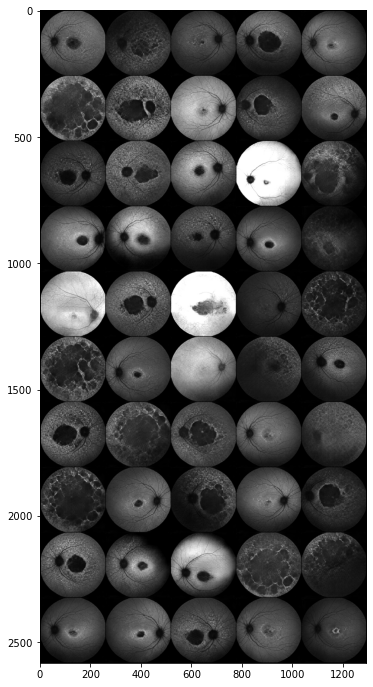

In [29]:
# visualize images
plt.figure(figsize=(12, 12))
_ = show_tensor_images(generated_images, normalize=False, show_image=True)

In [ ]:
# save_folder = "results/gif_imgs/"
# os.makedirs(save_folder, exist_ok=True)
# for i in range(len(generated_images)):
#     plt.figure(figsize=(12, 6))
#     plt.axis('off')
#     _ = show_tensor_images(generated_images[i], normalize=False, show_image=True, save_path=save_folder+"res_{}".format(i))

## Exploring the latent space

In [78]:
from scipy.stats import ttest_ind
right_eyes = [2, 7, 9, 10, 12, 15, 17, 20, 21, 23, 27, 30, 36, 38, 46, 47]
left_eyes = [0, 1, 3, 4, 8, 11, 13, 16, 18, 26, 29, 32, 33, 37, 40, 41, 42, 45, 48]

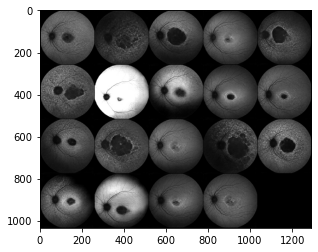

In [77]:
# visualize indexes below to confirm correct features are used
_ = show_tensor_images(generated_images[left_eyes], normalize=False, show_image=True)

In [310]:
# find the significantly different elements of right vs left eyes
latents_right = noise_and_labels[right_eyes] 
latents_left = noise_and_labels[left_eyes]
print(latents_right.shape, latents_left.shape)
_, pval = ttest_ind(latents_right[:, :512], latents_left[:, :512], axis=0)
sig_dif_idxs = np.concatenate((np.where(pval == np.min(pval), 1, 0), np.zeros(36)))[None, :]
laterality = (torch.mean(latents_left, dim=0)[None, :] - torch.mean(latents_right, dim=0)[None, :]) * sig_dif_idxs
laterality = laterality.type(torch.FloatTensor)
print("Components that affect laterality = {}".format(np.where(pval == np.min(pval))[0]))

torch.Size([16, 548]) torch.Size([19, 548])
Components that affect laterality = [262]


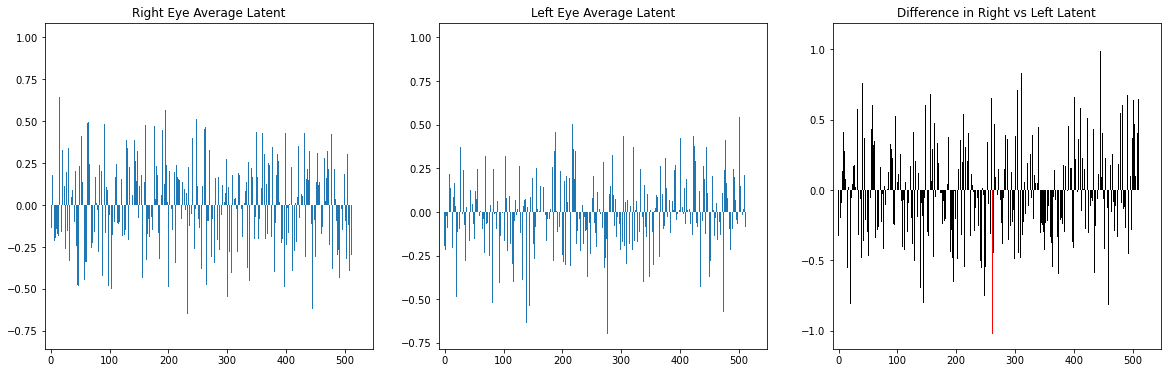

In [328]:
# visualize components
avg_right = torch.mean(latents_right, dim=0)
avg_left = torch.mean(latents_left, dim=0)

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.bar(x = np.arange(len(avg_right)), height = avg_right)
plt.bar(x = np.arange(len(avg_right)), height = avg_right*sig_dif_idxs.squeeze())
plt.xlim(-10, 548)
plt.title("Right Eye Average Latent")

plt.subplot(1, 3, 2)
plt.bar(x=np.arange(len(avg_left)), height=avg_left)
plt.bar(x = np.arange(len(avg_left)), height = avg_left*sig_dif_idxs.squeeze())
plt.xlim(-10, 548)
plt.title("Left Eye Average Latent")

plt.subplot(1, 3, 3)
plt.bar(x=np.arange(len(avg_right)), height=(avg_left - avg_right), color="black")
plt.bar(x=np.arange(len(avg_right)), height=(avg_left - avg_right)*sig_dif_idxs.squeeze(), color="red")
plt.title("Difference in Right vs Left Latent")

plt.xlim(-10, 548)
plt.show()

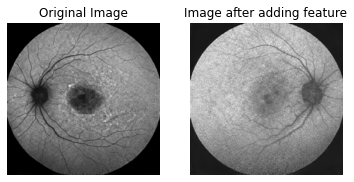

In [349]:
# add the laterality difference to a sample left image
sample_left = 0
factor = -100
transformed_latent = noise_and_labels[sample_left][None, :] + factor*laterality
with torch.no_grad():
    tranformed_image = gan_model(transformed_latent)[-1]
    
# visualize difference
plt.subplot(1, 2, 1)
plt.imshow(generated_images[sample_left].cpu().numpy().squeeze(), plt.cm.gray)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(tranformed_image.cpu().numpy().squeeze(), plt.cm.gray)
plt.title("Image after adding feature")
plt.axis("off")
plt.show()

## Interpolate between classes

In [ ]:
interpolator = Interpolate(gan_model, interp="classes", n_classes=dataset.n_classes, n_interpolation=9, device=device)

In [ ]:
noise = get_noise(1, 512, device)
class1 = 'USH2A'
class2 = 'USH2A'
class1_idx = torch.tensor([dataset.class2idx[class1]])
class2_idx = torch.tensor([dataset.class2idx[class2]])
interpolations = interpolator(noise, class1_idx, class2_idx)
image_adjustor = conditional_msggan.Generator.adjust_dynamic_range
interpolations[-1] = image_adjustor(interpolations[-1])

plt.figure(figsize=(20, 6))
_ = plt.axis('off')
_ = show_tensor_images(interpolations[-1], n_rows=9, normalize=False, show_image=True)

In [ ]:
# save_folder = "results/gif_imgs_2/"
# os.makedirs(save_folder, exist_ok=True)
# for i in range(len(interpolations[-1])):
# #     plt.figure(figsize=(6, 6))
#     plt.axis('off')
#     _ = show_tensor_images(interpolations[-1][i], normalize=False, show_image=True, save_path=save_folder+"res_{}".format(i))

## Interpolate between noises

In [ ]:
interpolator = Interpolate(gan_model, interp="latents", n_classes=dataset.n_classes, n_interpolation=9, device=device)

In [ ]:
label = 'USH2A'
class_idx = torch.tensor([dataset.class2idx[label]])
latent1 = get_noise(1, z_dim, device)
latent2 = get_noise(1, z_dim, device)
interpolations = interpolator(latent1, latent2, class_idx)
image_adjustor = conditional_msggan.Generator.adjust_dynamic_range
interpolations[-1] = image_adjustor(interpolations[-1])

plt.figure(figsize=(20, 6))
_ = plt.axis('off')
_ = show_tensor_images(interpolations[-1], n_rows=9, normalize=False, show_image=True)